### Feature Selection part 2 
<hr>

<p align=center>
<img src="https://www.researchgate.net/profile/Enis_Karaarslan/publication/337591149/figure/fig2/AS:830089595990017@1574920190654/The-main-feature-selection-methods-for-machine-learning.png" width="60%"></p>

<br>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline 
import warnings 
warnings.filterwarnings('ignore')

import functools 


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder 
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR 

In [2]:
data = pd.read_csv('data.csv')


data.drop('Unnamed: 32', axis=1, inplace=True)

X = data.drop('diagnosis', axis=1)
y= data['diagnosis']


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=14)



label = LabelEncoder()

y_train = label.fit_transform(y_train)
y_test = label.transform(y_test)


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

data.shape

(569, 32)

<br>
<hr>

### Chi2 


<br>
<b> Somente aplicado a Classificação </b> 


Calcule estatísticas de qui-quadrado entre cada recurso e classe não negativos.

Essa pontuação pode ser usada para selecionar as features n_features com os valores mais altos para a estatística qui-quadrado de teste de X, que deve conter apenas features não negativos, como booleanos ou frequências (por exemplo, contagens de termos na classificação de documentos), em relação ao Aulas.

Lembre-se de que o teste do qui-quadrado mede a dependência entre variáveis estocásticas, portanto, o uso dessa função “elimina” as features com maior probabilidade de serem independentes da classe e, portanto, irrelevantes para a classificação.

<hr>

In [3]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2

chi2 = functools.partial(chi2)

In [4]:
# Selecionar K=10 

selector = SelectKBest(score_func=chi2, k=10)
X_train2 = selector.fit_transform(X_train, y_train)
X_test2 = selector.transform(X_test)

In [5]:
mdl = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
mdl.fit(X_train2, y_train)
y_pred = mdl.predict(X_test2)

print(accuracy_score(y_test, y_pred))

0.9298245614035088


In [6]:
chi2 = functools.partial(chi2)
k=10 

resultados = []

for k in range(2,32,1):
    
    # SelectKBest 
    selector = SelectKBest(score_func=chi2, k=k)
    X_train2 = selector.fit_transform(X_train, y_train)
    X_test2 = selector.transform(X_test)
    
    # model 
    mdl = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
    mdl.fit(X_train2, y_train)
    y_pred = mdl.predict(X_test2)

    # métrica 
    scores = accuracy_score(y_test, y_pred)
    resultados.append(scores)
    
    # loop 
    print('K: {} | Score: {}'.format(k, scores))

K: 2 | Score: 0.8888888888888888
K: 3 | Score: 0.9005847953216374
K: 4 | Score: 0.935672514619883
K: 5 | Score: 0.9415204678362573
K: 6 | Score: 0.935672514619883
K: 7 | Score: 0.9239766081871345
K: 8 | Score: 0.935672514619883
K: 9 | Score: 0.9473684210526315
K: 10 | Score: 0.9298245614035088
K: 11 | Score: 0.9415204678362573
K: 12 | Score: 0.935672514619883
K: 13 | Score: 0.9298245614035088
K: 14 | Score: 0.935672514619883
K: 15 | Score: 0.9298245614035088
K: 16 | Score: 0.9415204678362573
K: 17 | Score: 0.9532163742690059
K: 18 | Score: 0.9532163742690059
K: 19 | Score: 0.9532163742690059
K: 20 | Score: 0.9473684210526315
K: 21 | Score: 0.9590643274853801
K: 22 | Score: 0.9532163742690059
K: 23 | Score: 0.9532163742690059
K: 24 | Score: 0.9532163742690059
K: 25 | Score: 0.9473684210526315
K: 26 | Score: 0.9473684210526315
K: 27 | Score: 0.9532163742690059
K: 28 | Score: 0.9532163742690059
K: 29 | Score: 0.9415204678362573
K: 30 | Score: 0.9532163742690059
K: 31 | Score: 0.9532163742

Text(0, 0.5, 'Acurácia')

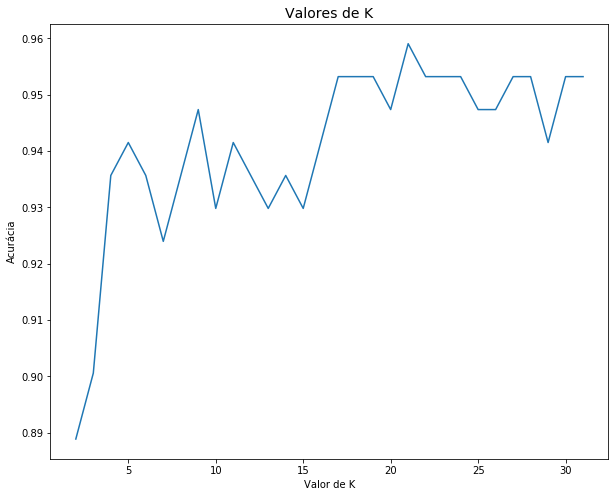

In [7]:
# avaliando valor de K 

pd.Series(resultados, index=range(2,32,1)).plot(figsize=(10,8))
plt.title('Valores de K', fontsize=14)
plt.xlabel('Valor de K')
plt.ylabel('Acurácia')

In [8]:
# features selecionadas K=21 
selector = SelectKBest(score_func=chi2, k=21)
selector.fit(X_train, y_train)

# máscara 
mask = selector.get_support()
X.columns[mask]

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'compactness_mean', 'concavity_mean', 'concave points_mean',
       'radius_se', 'perimeter_se', 'area_se', 'compactness_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

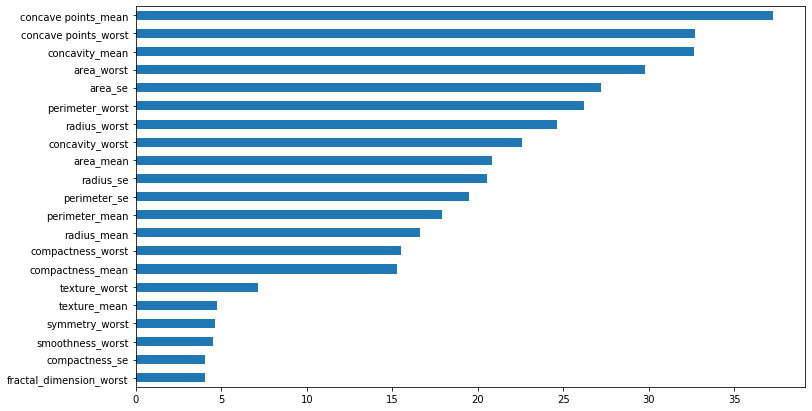

In [9]:
plt.figure(figsize=(12,7))
pd.Series(selector.scores_, index=X.columns).sort_values().tail(21).plot.barh()

<br>
<hr>
<hr>



### SelectFromModel


* Meta-transformador para selecionar features com base em pesos importantes.


No caso de modelos lineares, ele vai selecionar os maiores coeficientes dependendo do threshold definido, ou o número de features espcifíco. 


pode-se utilizar um modelo com coeficientes ou árvores, para identificar as feaures com os maiores pesos e usar em outro modelo, exemplo: SVM, KNN etc.
<br>

In [10]:
data = pd.read_csv('kc_house_data.csv')


data.drop(['id', 'date'], axis=1, inplace=True)

X = data.drop('price', axis=1)
y= data['price']


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=14)


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

data.shape

(21613, 19)

In [11]:
from sklearn.feature_selection import SelectFromModel

In [12]:
# Definindo modelo 
selector_model = LinearRegression(normalize=True)

# Sem threshold 
selector = SelectFromModel(selector_model, threshold=-np.inf, max_features=10)

# Selection 
X_train2 = selector.fit_transform(X_train, y_train)
X_test2 = selector.transform(X_test)


# Features selecionadas
X.columns[selector.get_support()]

Index(['bedrooms', 'bathrooms', 'sqft_living', 'waterfront', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long'],
      dtype='object')

In [13]:
mdl = LinearRegression(normalize=True)
mdl.fit(X_train2, y_train)
y_pred = mdl.predict(X_test2)


print(mean_absolute_error(y_test, y_pred))

130195.30747657723


In [14]:
# Gerar pesos com modelos lineares ou baseados em árvore 

k = 10 

for k in range(2,19,1):
    # Definindo modelo 
    selector_model = LinearRegression(normalize=True)

    # Sem threshold 
    selector = SelectFromModel(selector_model, threshold=-np.inf, max_features=k)

    # Selection 
    X_train2 = selector.fit_transform(X_train, y_train)
    X_test2 = selector.transform(X_test)

    # modelo
    mdl = LinearRegression(normalize=True)
    mdl.fit(X_train2, y_train)
    y_pred = mdl.predict(X_test2)

    # métrica 
    score = mean_absolute_error(y_test, y_pred)
    print('K: {} | MAE: {}'.format(k,score))

K: 2 | MAE: 168962.34656842143
K: 3 | MAE: 161921.55809636932
K: 4 | MAE: 159571.10595781004
K: 5 | MAE: 156224.82336877374
K: 6 | MAE: 138943.6526513695
K: 7 | MAE: 138587.25991065215
K: 8 | MAE: 129998.71227009498
K: 9 | MAE: 130195.30747657723
K: 10 | MAE: 130195.30747657723
K: 11 | MAE: 127771.90293563838
K: 12 | MAE: 127727.26185386608
K: 13 | MAE: 127599.15541757307
K: 14 | MAE: 127533.91707519814
K: 15 | MAE: 127069.11431229972
K: 16 | MAE: 126699.2149100575
K: 17 | MAE: 126467.12574020225
K: 18 | MAE: 126397.7658725416


In [15]:
# Testar com Random Forest 

#k = 10 

for k in range(2,19,1):
    # Definindo modelo para seleção  
    selector_model = Lasso(alpha=3.0, random_state=42)

    # Sem threshold 
    selector = SelectFromModel(selector_model, threshold=-np.inf, max_features=k)

    # Selection 
    X_train2 = selector.fit_transform(X_train, y_train)
    X_test2 = selector.transform(X_test)

    # modelo
    mdl = RandomForestRegressor(n_estimators=100, random_state=42)
    mdl.fit(X_train2, y_train)
    y_pred = mdl.predict(X_test2)

    # métrica 
    score = mean_absolute_error(y_test, y_pred)
    print('K: {} | MAE: {}'.format(k,score))

K: 2 | MAE: 172954.8502888228
K: 3 | MAE: 163374.79806653678
K: 4 | MAE: 158726.90472282123
K: 5 | MAE: 101763.76274143558
K: 6 | MAE: 97700.91250851058
K: 7 | MAE: 88054.23976979476
K: 8 | MAE: 73134.63927958198
K: 9 | MAE: 72008.21464272495
K: 10 | MAE: 71696.48424292398
K: 11 | MAE: 70403.22280422506
K: 12 | MAE: 70283.08818495712
K: 13 | MAE: 69631.5273415881
K: 14 | MAE: 69056.62986340736
K: 15 | MAE: 68666.53248920052
K: 16 | MAE: 68860.80964138098
K: 17 | MAE: 68703.5964821906
K: 18 | MAE: 68655.67569245542


In [16]:
# Selecionando | Coeficientes Linear Regression
selector_model = LinearRegression(normalize=True)

# Seletor 
selector = SelectFromModel(selector_model, threshold=-np.inf, max_features=18)
X_train2 = selector.fit_transform(X_train, y_train)
X_test2 = selector.transform(X_test)

In [17]:
mdl = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)
mdl.fit(X_train2, y_train)
y_pred = mdl.predict(X_test2)

In [18]:
mean_absolute_error(y_test, y_pred)

68230.50799184568

<br>
<hr>
<br>
<hr>

### Recursive Feature Elimination - RFE 


Classificação de recursos com eliminação recursiva de recursos.

Dado um estimador externo que atribui pesos a recursos (por exemplo, os coeficientes de um modelo linear), o objetivo da eliminação recursiva de recursos (RFE) é selecionar recursos considerando recursivamente, considerando conjuntos cada vez menores de recursos. Primeiro, o estimador é treinado no conjunto inicial de recursos e a importância de cada recurso é obtida por meio de um coef_atributo ou por um feature_importances_atributo. Em seguida, os recursos menos importantes são removidos do conjunto atual de recursos. Esse procedimento é repetido recursivamente no conjunto podado até que o número desejado de recursos a serem selecionados seja finalmente alcançado.

<hr>

In [19]:
from sklearn.feature_selection import RFE 

In [20]:
# Modelo 
model = RandomForestRegressor(n_estimators=500, random_state=42)

# RFE 
selector = RFE(model, n_features_to_select=10, step=1)
selector.fit_transform(X_train, y_train)
selector.transform(X_test)

array([[0.10867925, 0.00304482, 0.        , ..., 0.42114094, 0.22086957,
        0.00614859],
       [0.19773585, 0.00453673, 0.        , ..., 0.39513423, 0.42608696,
        0.00776654],
       [0.11698113, 0.00728351, 0.        , ..., 0.09983221, 0.24695652,
        0.01233825],
       ...,
       [0.19471698, 0.00398789, 0.        , ..., 0.13003356, 0.20347826,
        0.01311508],
       [0.13433962, 0.04641261, 0.        , ..., 0.32802013, 0.30086957,
        0.08751781],
       [0.03396226, 0.00542828, 0.        , ..., 0.11241611, 0.04869565,
        0.01105246]])

In [21]:
# Features selecionadas 
mask = selector.get_support()
print(X.columns[mask])

Index(['sqft_living', 'sqft_lot', 'waterfront', 'grade', 'sqft_above',
       'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [22]:
#k = 5

for k in range(2,19,1):
    
    # modelo 
    model = Ridge(alpha=1.0, random_state=42)
    
    # Seletor
    selector = RFE(model, n_features_to_select=k, step=1)
    selector.fit_transform(X_train, y_train)
    selector.transform(X_test)
    
    # métrica 
    score = mean_absolute_error(y_test, y_pred)
    print('K: {} | MAE: {}'.format(k, score))

K: 2 | MAE: 68230.50799184568
K: 3 | MAE: 68230.50799184568
K: 4 | MAE: 68230.50799184568
K: 5 | MAE: 68230.50799184568
K: 6 | MAE: 68230.50799184568
K: 7 | MAE: 68230.50799184568
K: 8 | MAE: 68230.50799184568
K: 9 | MAE: 68230.50799184568
K: 10 | MAE: 68230.50799184568
K: 11 | MAE: 68230.50799184568
K: 12 | MAE: 68230.50799184568
K: 13 | MAE: 68230.50799184568
K: 14 | MAE: 68230.50799184568
K: 15 | MAE: 68230.50799184568
K: 16 | MAE: 68230.50799184568
K: 17 | MAE: 68230.50799184568
K: 18 | MAE: 68230.50799184568
